# import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import os
from os.path import join
import shutil
from sklearn.preprocessing import normalize
from collections import OrderedDict
import pickle

from tqdm import tqdm
from sklearn import preprocessing # Path 
import matplotlib.pyplot as plt
import cv2
import argparse
import subprocess
from Common import get_rmac_region_coordinates
from Common import pack_regions_for_network
from Common import L2Normalization
from Common import Shift
from Common import RoIPool
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from RegionAttentionNetwork import ContextAwareRegionalAttentionNetwork

In [2]:
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.io import read_image

In [3]:
from efficientnet_pytorch import EfficientNet

# Path 

In [4]:
data_path = '/tf/DUBU_Kaier/TOFU_BOX_margin'
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test_1345')

# Load tofu datasets

In [5]:
class TofuDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, encoding='cp949')
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)        
        if self.target_transform:
            label = self.target_transform.transform([label])[0]


        return image, label

In [6]:
def global_contrast_normalization(x: torch.tensor, scale='l2'):
    """
    Apply global contrast normalization to tensor, i.e. subtract mean across features (pixels) and normalize by scale,
    which is either the standard deviation, L1- or L2-norm across features (pixels).
    Note this is a *per sample* normalization globally across features (and not across the dataset).
    """

    assert scale in ('l1', 'l2')

    n_features = int(np.prod(x.shape))
    
    x = x.float()

    mean = torch.mean(x)  # mean over all features (pixels) per sample
    x -= mean

    if scale == 'l1':
        x_scale = torch.mean(torch.abs(x))

    if scale == 'l2':
        x_scale = torch.sqrt(torch.sum(x ** 2)) / n_features

    x /= x_scale

    return x

In [7]:
# Pre-computed min and max values (after applying GCN) from train data per class
min_ = - 4.4943
max_ = 2.3380

In [8]:
transform = transforms.Compose([
                                transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
                                transforms.Normalize([min_],
                                                     [max_ - min_])
                                ])

In [9]:
folders = ['정상A', '정상B', '금속', '머리카락', '벌레', '상단불량D', '상단불량E', '유바', '탄화물', '플라스틱']
le = preprocessing.LabelEncoder()
le.fit(folders)

LabelEncoder()

In [10]:
le_name_mapping = dict(zip(le.transform(le.classes_),le.classes_))
le_name_mapping

{0: '금속',
 1: '머리카락',
 2: '벌레',
 3: '상단불량D',
 4: '상단불량E',
 5: '유바',
 6: '정상A',
 7: '정상B',
 8: '탄화물',
 9: '플라스틱'}

In [11]:
target_transform = le

In [12]:
le.transform(['정상A'])[0]

6

In [13]:
train_dataset = TofuDataset('train_annotations.csv', train_path, transform, target_transform )
valid_dataset = TofuDataset('valid_annotations.csv', valid_path, transform, target_transform)
test_dataset = TofuDataset('test_annotations.csv', test_path, transform, target_transform)

In [30]:
batch_size= 8
dataloaders = {}
# dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=0)
# dataloaders['val'] = DataLoader(valid_dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=0)
dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

In [16]:
#check dataloader shape
for img, label in dataloaders['test']:
    print(img.shape)
    print(label)
    break

torch.Size([4, 3, 640, 640])
tensor([6, 6, 6, 6])


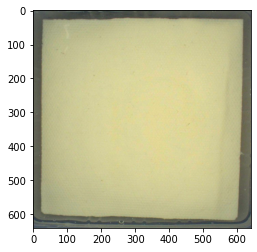

In [17]:
# example image from data loader
plt.imshow(np.transpose(img[0], (1,2,0)).cpu())

# Model

In [18]:
class OurNet(nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()

        self.l2norm = L2Normalization()
        #RoI max pooling
        self.r_mac_pool = RoIPool(1, 1, 0.03125)
        #Define regional attention network 
        self.region_attention = ContextAwareRegionalAttentionNetwork(spatial_scale = 0.03125)

        self.pca_shift = Shift(2048)
        self.pca_fc = nn.Linear(2048, 2048, bias=False)
        
        #Load the PCA weights learned with off-the-shelf Resnet101
        # self.pca_fc.weight.data = torch.Tensor(np.load('pca_components.npy'))
        # self.pca_shift.bias.data = torch.Tensor(np.load('pca_mean.npy'))


        #Load efficientnet
        
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)  
        self.efficientnet.load_state_dict(torch.load('GCN_efficientnet_b0_president_model.pt'))
        


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x, ):
        #Calculate R-MAC regions (Region sampling)
    
        batched_rois = [get_rmac_region_coordinates(x.shape[2], x.shape[3], 5) for i in range(x.shape[0])]
        region_size = len(batched_rois[0])
        rois = Variable(torch.FloatTensor(pack_regions_for_network(batched_rois)))

        h = x
        #Extract feature map
        h = self.efficientnet.extract_features(x)  # ( #batch, #channel, #h, #w)

        #R-MAC module
        g = self.r_mac_pool(h, rois)
        g = g.squeeze(2).squeeze(2)  # (#batch * # regions, #channel)
        #g = self.pca_shift(g)  # PCA
        #g = self.pca_fc(g)
        g = self.l2norm(g)  # normalize each region
       
        
        #Regional attention module
        g2 = self.region_attention(h, rois)
        g2 = g2.squeeze(0).squeeze(0)  # (# batch * region)
        
        # store attention score
        idx_list=[]
        idx_=[]
        
        for idx, i in enumerate(g2):   
              idx_list.append((idx,i))
              idx_.append(idx)
                
                
        #Weighted mean
        g = torch.mul(g.transpose(1, 0), g2).transpose(1, 0)  # regional weighted feature (# batch * region, #channel)
        g = g.contiguous()
        g = g.view(torch.Size([h.size(0), -1, h.size(1)]))  # (#batch, # region, # channel)
        g = torch.transpose(g, 1, 2)  # (#batch * #channel, #region)
        g = torch.mean(g, 2)

        #Final L2

        g = self.l2norm(g)  # (batch, 1280)

        return g, rois, idx_list

In [19]:
net = OurNet()

Loaded pretrained weights for efficientnet-b0


In [20]:
net = net.to('cuda:0')

In [21]:
net.region_attention

ContextAwareRegionalAttentionNetwork(
  (conv_att_1): Conv1d(2560, 64, kernel_size=(1,), stride=(1,))
  (sp_att_1): Softplus(beta=1, threshold=20)
  (conv_att_2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  (sp_att_2): Softplus(beta=1, threshold=20)
)

# regional attenion layer w load

In [22]:
dic = torch.load('GCN_regional_attention_efficientnet.pt')

In [23]:
net.region_attention.conv_att_1.weight.data=dic['region_attention.conv_att_1.weight']
net.region_attention.conv_att_1.bias.data=dic['region_attention.conv_att_1.bias']
net.region_attention.conv_att_2.weight.data=dic['region_attention.conv_att_2.weight']
net.region_attention.conv_att_2.bias.data=dic['region_attention.conv_att_2.bias']

In [24]:
net.eval()
gpu_num = 0
net = net.cuda(gpu_num)  

# load pred_list and true_list of regional attention class net

In [25]:
with open('regional_attention_class_net_results.pickle', 'rb') as f:
    class_results = pickle.load(f)  

In [26]:
pred_list = class_results['pred_list']
true_list = class_results['true_list']

# extract ROI

In [27]:
class ImageHelper:    
    def __init__(self):
        pass
    
    def get_features(self, I, net, gpu_num):

        output, rois, idx_list = net(Variable(I.cuda(gpu_num)))

        return output, rois, idx_list



In [28]:
image_helper = ImageHelper()

In [29]:
def extract_roi_features( image_helper, net, image, gpu_num):

    _, rois, idx_list = image_helper.get_features(image, net, gpu_num)
    return rois, idx_list



### 모든 test 데이터셋에 대해서 ROI region과 attention idx 뽑기 

In [31]:
gpu_num = 0 

def tensor_to_list(x):
    return x[1].cpu().tolist()

tol_rois_list = []
idx_group = []
tol_query_list = []

for i, (img, label) in tqdm(enumerate(dataloaders['test'])):
    '''
        tol_rois_list: image 내의 ROI region 좌표 
        idx_group: (index, attention score)
        tol_query_list: 
    '''

    tol_rois, tol_query  = extract_roi_features(image_helper, net, img, gpu_num)
    # sort by attention score
    idx_list = [sorted(tol_query, key=lambda x:-x[1])[i][0] for i in range(len(tol_query))]
    if i==0: 
        tol_rois_list.append(tol_rois.cpu().numpy())

    idx_group.append(idx_list)    
    tol_query_list.append(list(map(tensor_to_list, tol_query)))
    break 
 

  

0it [08:49, ?it/s]


KeyboardInterrupt: 

In [47]:
tol_query_list

[[0.30426594614982605,
  0.08987519145011902,
  0.14043307304382324,
  0.44721823930740356,
  0.5335093140602112,
  0.06579737365245819,
  0.07618687301874161,
  0.18740244209766388,
  0.1847502589225769,
  0.059198495000600815,
  0.13372044265270233,
  0.5692519545555115,
  0.3860895037651062,
  0.9912970662117004,
  0.04837217926979065,
  0.04527876153588295,
  0.10993271321058273,
  0.2522493898868561,
  0.08379273116588593,
  0.03121144138276577,
  0.06706230342388153,
  0.1059805303812027,
  0.24883857369422913,
  0.05418463423848152,
  0.0658157616853714,
  0.22020545601844788,
  0.7024989128112793,
  0.41728702187538147,
  0.7378086447715759,
  1.4417601823806763,
  0.03941890597343445,
  0.026648199185729027,
  0.1070653423666954,
  0.13415132462978363,
  0.29788628220558167,
  0.035368550568819046,
  0.011356391943991184,
  0.05794834718108177,
  0.08581296354532242,
  0.10835286974906921,
  0.2560291290283203,
  0.046550311148166656,
  0.05057620257139206,
  0.078114844858646

In [43]:
img.shape

torch.Size([1, 3, 640, 640])

In [ ]:
img.shape

In [ ]:
tol_query_list

In [ ]:
idx_group

In [ ]:
tol_dict = {}
tol_dict['tol_rois'] = tol_rois_list
tol_dict['attention_idx'] = idx_group

In [ ]:
len(idx_group)

In [ ]:
with open('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/test_data_attention_idx.pickle', 'wb') as f:
  pickle.dump(tol_dict, f)

In [ ]:
with open('/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/test_data_attention_idx.pickle', 'rb') as f:
  tmp_dict = pickle.load(f)

In [ ]:
tol_rois_list = tmp_dict['tol_rois']
idx_group = tmp_dict['attention_idx']

In [ ]:
tol_query

In [ ]:
i=0
for img, label in dataloaders['roi_test']:
    print(img)
    if i==2:
        break
    i+=1
    

In [ ]:
len(tol_rois_list)

In [ ]:
tol_rois_list[0]

In [ ]:
idx_group[-10:]

# draw roi box

In [ ]:
PIL_color_name_list = []
for name, code in PIL.ImageColor.colormap.items():
  PIL_color_name_list.append(name)
PIL_color_name_list

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgrey',
 'darkgreen',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'grey',
 'green',
 'greenyellow',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgreen',


In [ ]:
def pil_draw_rect2(image, roi_list):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    #color = ['red', 'yellow']
    for i, roi in enumerate(roi_list):
            draw.rectangle(((roi[1], roi[2]), (roi[3], roi[4])), outline=PIL_color_name_list[i], width=1)
    return image

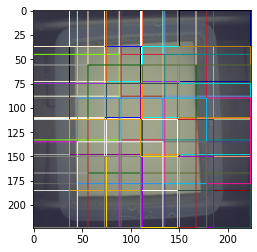

In [ ]:
# 모든 region을 plot
image = pil_draw_rect2(test_image[0],tol_rois_list[0][np.array(idx_group)][0])
numpy_image = np.array(image)

plt.imshow(numpy_image)
plt.show()

In [ ]:
import PIL
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt

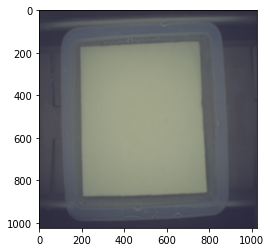

In [ ]:
im = test_image[0]
im_size_hw = np.array(im.shape[0:2])
ratio = float(1024) / np.max(im_size_hw)
new_size = tuple(np.round(im_size_hw * ratio).astype(np.int32))  #(854, 1024)
im_resized = cv2.resize(im, (new_size[1], new_size[0]))
#image_rgb = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)
plt.imshow(im_resized)

In [ ]:
def pil_draw_rect(image, roi_list):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    color = ['red', 'yellow']
    for i, roi in enumerate(roi_list):
            draw.rectangle(((roi[1], roi[2]), (roi[3], roi[4])), outline=color[i], width=1)
    return image

In [ ]:
tol_rois

tensor([[   0.,    0.,    0.,  853.,  853.],
        [   0.,  170.,    0., 1023.,  853.],
        [   0.,    0.,    0.,  568.,  568.],
        [   0.,  227.,    0.,  795.,  568.],
        [   0.,  455.,    0., 1023.,  568.],
        [   0.,    0.,  285.,  568.,  853.],
        [   0.,  227.,  285.,  795.,  853.],
        [   0.,  455.,  285., 1023.,  853.],
        [   0.,    0.,    0.,  426.,  426.],
        [   0.,  199.,    0.,  625.,  426.],
        [   0.,  398.,    0.,  824.,  426.],
        [   0.,  597.,    0., 1023.,  426.],
        [   0.,    0.,  213.,  426.,  639.],
        [   0.,  199.,  213.,  625.,  639.],
        [   0.,  398.,  213.,  824.,  639.],
        [   0.,  597.,  213., 1023.,  639.],
        [   0.,    0.,  427.,  426.,  853.],
        [   0.,  199.,  427.,  625.,  853.],
        [   0.,  398.,  427.,  824.,  853.],
        [   0.,  597.,  427., 1023.,  853.],
        [   0.,    0.,    0.,  340.,  340.],
        [   0.,  170.,    0.,  510.,  340.],
        [ 

In [ ]:
image = pil_draw_rect(image_rgb,tol_rois_list[2000][idx_group[2000]])

numpy_image = np.array(image)

plt.imshow(numpy_image)
plt.show()

NameError: ignored

# Fail case study

In [ ]:
le_name_mapping = dict(zip(le.transform(le.classes_),le.classes_))
le_name_mapping

{0: '금속',
 1: '머리카락',
 2: '벌레',
 3: '상단불량D',
 4: '상단불량E',
 5: '유바',
 6: '정상A',
 7: '정상B',
 8: '탄화물',
 9: '플라스틱'}

### predict = 상단D, true = 정상B

In [ ]:
idx_ = ((np.array(pred_list) == 3) & (np.array(true_list)==7))

In [ ]:
test_image

array([[[[53, 52, 70],
         [53, 52, 68],
         [53, 52, 68],
         ...,
         [45, 46, 64],
         [45, 45, 63],
         [43, 43, 57]],

        [[53, 53, 68],
         [54, 53, 68],
         [53, 52, 68],
         ...,
         [46, 46, 65],
         [46, 46, 64],
         [44, 44, 59]],

        [[53, 52, 68],
         [53, 52, 68],
         [53, 52, 68],
         ...,
         [49, 48, 67],
         [49, 48, 65],
         [46, 45, 61]],

        ...,

        [[46, 45, 63],
         [46, 45, 63],
         [46, 45, 63],
         ...,
         [45, 44, 61],
         [47, 45, 64],
         [45, 44, 59]],

        [[46, 45, 64],
         [46, 45, 64],
         [46, 45, 63],
         ...,
         [45, 44, 62],
         [47, 45, 64],
         [45, 45, 60]],

        [[42, 41, 58],
         [43, 42, 58],
         [43, 42, 58],
         ...,
         [41, 40, 56],
         [42, 41, 58],
         [41, 40, 55]]],


       [[[54, 56, 71],
         [53, 55, 70],
         [53, 

In [ ]:
idx_.sum()

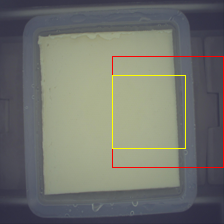

In [ ]:
pil_draw_rect(test_image[idx_][0],tol_rois_list[0][np.array(idx_group)[idx_][0]])

In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_정상B",str(i)+".png"))

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=정상B, true=상단D

In [ ]:
idx_ = ((np.array(pred_list) == 7) & (np.array(true_list)==3))
print(idx_.sum())

173


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_상단D",str(i)+".png"))

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=정상B, true=유바

In [ ]:
idx_ = ((np.array(pred_list) == 7) & (np.array(true_list)==5))
print(idx_.sum())

13


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_유바",str(i)+".png"))

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=정상A, true=유바

In [ ]:
idx_ = ((np.array(pred_list) == 6) & (np.array(true_list)==5))
print(idx_.sum())

4


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_유바/predict_정상A",str(i)+".png"))

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=정상B, true=정상B

In [ ]:
idx_ = ((np.array(pred_list) == 7) & (np.array(true_list)==7))
print(idx_.sum())

2196


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_정상B_predict_정상B",str(i)+".png"))

  if i==100:
    break

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=상단D, true=상단D

In [ ]:
idx_ = ((np.array(pred_list) == 3) & (np.array(true_list)==3))
print(idx_.sum())

653


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_상단D_predict_상단D",str(i)+".png"))

  if i==100:
    break

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

### predict=벌레, true=벌레 

In [ ]:
idx_ = ((np.array(pred_list) == 2) & (np.array(true_list)==2))
print(idx_.sum())

83


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_벌레",str(i)+".png"))

  if i==100:
    break

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()

In [ ]:
!rm /content/drive/MyDrive/Kaier_Tofu_Data/Regional\ attention/Fail\ case\ study/true_벌레/*

### predict=머리카락, ture=머리카락

In [ ]:
idx_ = ((np.array(pred_list) == 1) & (np.array(true_list)==1))
print(idx_.sum())

126


In [ ]:
for i in range(idx_.sum()):
  image = pil_draw_rect(test_image[idx_][i],tol_rois_list[0][np.array(idx_group)[idx_][i]])

  # save image
  image.save(os.path.join("/content/drive/MyDrive/Kaier_Tofu_Data/Regional attention/Fail case study/true_머리카락",str(i)+".png"))

  if i==100:
    break

  # plot image
  # numpy_image = np.array(image)

  # plt.savefig()

  # plt.imshow(numpy_image)
  # plt.show()